<center>
<h1 style="font-family:verdana">
 💻 🧑 Reconeixement d'entitats anomenades 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta segona part de la pràctica aprendrem a reconèixer entitats anomenades, és a dir, identificar i classificar entitats en una oració que poden ser (en el context de reserva de vols) la ciutat de sortida o d'arribada, la data del mes i el dia, si es de negocis o turista o altres categories específiques. Aquesta tasca se sol plantejar etiquetant cada paraula amb una etiqueta de la categoria de l'entitat a la qual correspon.

Tant la classificació d'intencions (tasca estudiada a la primera part) com el reconeixement d'entitats anomenades (Name Entity Recognition, NER) que veurem en aquesta part són components crucials dels sistemes de processament del llenguatge natural (Natural Language Processing, NLP) i sovint s'utilitzen junts per crear aplicacions d'intel·ligència artificial (IA) conversacionals més sofisticades. Per exemple, en un xatbot, la classificació d'intencions ajuda a entendre la intenció principal de l'usuari, mentre que el reconeixement d'entitats anomenades ajuda a extreure entitats rellevants per proporcionar respostes més contextualitzades.


<p> ✨ <b>Contingut</b>: els passos d'aquesta segona part seran similars a la primera. En primer lloc, analitzarem el conjunt de dades. En segon lloc, prepararem les dades per a poder entrenar el model. I finalment dissenyarem l'arquitectura i entrenarem el model. </p>


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>

Notebook realitzat per:
- Marta Juncarol Pi
- Jaume Mora Ladària
- Abril Risso Matas

---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
  * [Exercici 2](#ex-two)
2. [Preprocessament de dades](#section-two)
  * [Exercici 3](#ex-three)
  * [Exercici 4](#ex-four)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 5](#ex-five)
  * [Exercici 6](#ex-six)
4. [Lliurable](#section-four)

---

In [ ]:
import keras
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, Dense, TimeDistributed, LSTM, GRU, Bidirectional, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical

<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

In [3]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: c:\Users\marta\tercer\TVD\lab2\nlu_ATIS_data.tar.gz

  0%|          | 0.00/122k [00:00<?, ?B/s]
100%|██████████| 122k/122k [00:00<00:00, 2.49MB/s]


In [4]:
!ls data

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


En aquesta segona part de la pràctica utilitzarem el mateix dataset que a la primera part, però en aquest cas utilitzarem la **primera columna** que correspon a les **oracions** introduïdes pels usuaris i la **segona columna** on trobarem les oracions d'entrada en format **BILOU**.

El format BILOU  és un esquema d'etiquetatge que es fa servir a les tasques de reconeixement d'entitats anomenades. El nom *BILOU* representa les etiquetes utilitzades en aquest esquema:

*   **B** - Beginning: primer token d'una entitat.
*   **I** - Inside: token dins d'una entitat.
*   **L** - Last: últim token de l'entitat.
*   **O** - Outside: token que no pertany a cap entitat.
*   **U** - Unit: entitats d'un sol token

A continuació, carregarem les dades per visualitzar i poder entendre millor aquestes etiquetes.

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

A continuació us demanem que carregueu els dos CSVs de la carpeta `data`: `train.csv`, `test.csv` utilitzant pandas. Recorda que aquests CSVs no tenen capçalera. Agafeu les 900 últimes lineas del fitxer `train.csv` per crear un dataframe per validació.

In [5]:
train_data = pd.read_csv('data/train.csv', header=None)
test_data = pd.read_csv('data/test.csv', header=None)
val_data = train_data.tail(900)
train_data = train_data.head(len(train_data)-900)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Tal com hem introduït abans, per a aquest exercici ens centrarem en la **primera** i la **segona** columna. Per tant, ara us demanem que guardeu en les següents variables, les llistes corresponents a les oracions i a les etiquetes de les tres particions (`train`, `validation` i `test`).

In [6]:
train_data.head()

,0,1,2
0,i want to fly from boston at 838 am and arrive...,"""O O O O O B-fromloc.city_name O B-depart_tim...","""flight"""
1,what flights are available from pittsburgh to ...,"""O O O O O B-fromloc.city_name O B-toloc.city...","""flight"""
2,what is the arrival time in san francisco for ...,"""O O O B-flight_time I-flight_time O B-fromlo...","""flight_time"""
3,cheapest airfare from tacoma to orlando,"""B-cost_relative O O B-fromloc.city_name O B-...","""airfare"""
4,round trip fares from pittsburgh to philadelph...,"""B-round_trip I-round_trip O O B-fromloc.city...","""airfare"""


In [7]:
train_sentences = train_data[0].tolist()
train_labels = list(s.replace('"', '') for s in train_data[1])

val_sentences = val_data[0].tolist()
val_labels = list(s.replace('"', '') for s in val_data[1])

test_sentences = test_data[0].tolist()
test_labels = list(s.replace('"', '') for s in test_data[1])


---

Si tot ha anat bé ja podem analitzar quin aspecte té el format BILOU.

In [8]:
print(train_sentences[5])
print(train_labels[5])

i need a flight tomorrow from columbus to minneapolis
 O O O O B-depart_date.today_relative O B-fromloc.city_name O B-toloc.city_name


Aquest hauria de ser el resultat obtingut si executeu la cel·la anterior:

```


i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 "O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day"


```

En aquest exemple, `boston` i `838 am` corresponen a l'entitat "ciutat de sortida" i a l'entitat "hora de sortida" respectivament (`fromloc.city_name`,`depart_time.time`). `838` correspon al primer token que pertany la entitat `depart_time.time` i `am` al segon de la mateixa entitat. Els tokens com `i` o `want` no pertanyen a cap entitat.

In [9]:
print(train_sentences[1])
print(train_labels[1])

what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day


I aquest hauria de ser el resultat de la cel·la anterior:

```
what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day
```

En l'anterior exemple, `what`, `flights`, `are`, `available`, `from`, `to` i `on` estan etiquetades com a no pertanyents a cap entitat. I, en canvi, `pittsburgh` pertany a l'entitat d'un sol token anomenada ciutat d'arribada (`toloc.city_name`). També hi ha entitats compostes com `baltimore` que pertany a l'entitat ciutat de sortida (`fromloc.city_name`) i `thursday morning` que pertanyen a les entitats data de sortida (`depart_date.day_name`, `depart_time.period_of_day`).

Vegem-ne la llista completa d'entitats.

In [10]:
from collections import Counter

def count_unique_entities(list_of_label_sentences):
  flat_labels = []
  for labels in list_of_label_sentences:
    flat_labels += labels.split()
  c = Counter(flat_labels)
  return len(c), list(c.keys())

num_unique_entities, unique_entities = count_unique_entities(train_labels)

print("Number of different entities:", num_unique_entities)

print("Unique entities:", unique_entities)

Number of different entities: 119
Unique entities: ['O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B-flight_m

<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

El processament de les dades serà semblant al de la primera part d'aquesta pràctica.

---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

En aquest exercici us demanem que realitzeu els passos següents per preparar les dades.

 1. El primer pas serà construir el vocabulari a partir de les paraules presents a les oracions d'entrenament.

2. El segon pas serà convertir les oracions en seqüències de nombres enters usant el tokenitzador.

3. El tercer pas serà guardar la longitud original de cada oració. Això ens serà útil per evaluar el nostre model sense tenir en compte el padding.

3. Finalment, per aconseguir que totes les seqüències tinguen la mateixa longitud, fixarem la longitud segons la màxima trobada a l'entrenament i afegirem zeros a les oracions de menor longitud.

Recordeu que podeu consultar com fer-ho a la documentació de la llibrería:
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer"> Tokenizer </a>
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences"> Pad Sequences </a>




In [11]:
num_words=500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
len_train_sequences = [len(seq) for seq in train_sequences]
max_sequence_length = max(len_train_sequences)
print(max_sequence_length)
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

val_sequences = tokenizer.texts_to_sequences(val_sentences)
len_val_sequences = [len(seq) for seq in val_sequences]
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
len_test_sequences = [len(seq) for seq in test_sequences]
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

46


In [12]:
train_pad_sequences[0]

array([ 12,  69,   1,  38,   2,   9,  64, 415,  84,  17,  75,  16,  13,
        64, 493,  16,   4,  36,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)


---



Tal com vam fer a la primera part, aquí també hem de convertir les diferents classes d'entitats en vectors one-hot.

---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

Per aconseguir-ho haureu de seguir els passos següents.

 1. En primer lloc, haureu d'esbrinar quantes etiquetes diferents hi ha. Podeu prendre com a exemple la funció `count_unique_entities` per fer-ho. Tingueu en compte que haureu de modificar la funció, ja que per exemple aquesta funció considera que `B-depart_time.time`, `I-depart_time.time`, `L-depart_time.time`, `U-depart_time.time` són la mateixa entitat. En aquest exercici, necessitarem comptar-les per separat. També l'entitat O ha de ser considerada com una classe.

 2. El segon pas serà codificar les diferents classes trobades en etiquetes numèriques. Tingueu en compte que cada paraula de l'oració té una etiqueta i, per tant, per a cada oració tindrem una llista d'etiquetes. El *padding* el codificarem amb l'etiqueta corresponent a **O** (outside). Per ajudar-vos hem preparat el processament per a les etiquetes d'entrenament, intenteu comprendre el que es fa i així repetir-ho per a la partició de validació i test.

 3. Finalment, haureu de convertir les diferents classes a vectors one-hot. Recordeu de nou que per a cada oració tindrem una llista de vectors one-hot.


 Podeu consultar els apartats de la documentació:
 * <a href=https://www.tensorflow.org/guide/keras/understanding_masking_and_padding> Masking and Padding </a>

 * <a href=https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical> To Categorical </a>



In [13]:
# Step 1: Counting Unique Entities
def count_unique_entities(list_of_label_sentences):
    flat_labels = []
    for labels in list_of_label_sentences:
        flat_labels += labels.split()
    c = Counter(flat_labels)
    unique_entities = list(c.keys())
    return len(unique_entities), unique_entities

num_unique_entities, unique_entities = count_unique_entities(train_labels)

def count_unique_words(list_of_sentences):
    flat_sentences = []
    for sentences in list_of_sentences:
        flat_sentences += sentences.split()
    c = Counter(flat_sentences)
    unique_words = list(c.keys())
    return len(unique_words), unique_words

num_unique_words, unique_words_dict = count_unique_words(train_sentences)

print("Number of different entities:", num_unique_entities)
print("Unique entities:", unique_entities)

# Step 2: Label Encoding and Padding
# Initialize LabelEncoder and fit on unique_entities
label_encoder = LabelEncoder()
label_encoder.fit(unique_entities)

# Transform train_labels into numerical labels
train_labels_split = [labels.split() for labels in train_labels]
train_numerical_labels = [label_encoder.transform(labels) for labels in train_labels_split]  # +1 to reserve 0 for padding

# Determine the maximum sequence length
max_len = train_pad_sequences.shape[1]

# Pad the training labels
train_pad_labels = pad_sequences(train_numerical_labels, maxlen=max_len, padding='post', value=0)

def remove_sentences(list_labels, list_sequences):
    idx_to_remove = []
    labels_to_remove = []
    for idx, labels in enumerate(list_labels):
        for label in labels:
            if label not in unique_entities:
                idx_to_remove.append(idx)
                labels_to_remove.append(label)

    labels = [elem for i, elem in enumerate(list_labels) if i not in idx_to_remove]
    sequences = [elem for i, elem in enumerate(list_sequences) if i not in idx_to_remove]
    return labels, np.array(sequences)

# Process test data
_test_labels = [labels.split() for labels in test_labels]
test_labels, test_pad_sequences = remove_sentences(_test_labels, test_pad_sequences)
test_numerical_labels = [label_encoder.transform(labels) for labels in test_labels]
test_pad_labels = pad_sequences(test_numerical_labels, maxlen=max_len, padding='post', value=0)

# Process validation data
_val_labels = [labels.split() for labels in val_labels]
val_labels, val_pad_sequences = remove_sentences(_val_labels, val_pad_sequences)
val_numerical_labels = [label_encoder.transform(labels) for labels in val_labels]
val_pad_labels = pad_sequences(val_numerical_labels, maxlen=max_len, padding='post', value=0)

# Step 3: One-Hot Encoding
# Number of classes (+1 for padding label)
num_classes = num_unique_entities + 1  # +1 because we reserved 0 for padding

# One-hot encode the training labels
train_labels_one_hot = to_categorical(train_pad_labels, num_classes=num_classes)

# One-hot encode the test labels
test_labels_one_hot = to_categorical(test_pad_labels, num_classes=num_classes)

# One-hot encode the validation labels
val_labels_one_hot = to_categorical(val_pad_labels, num_classes=num_classes)

Number of different entities: 119
Unique entities: ['O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B-flight_m

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

---
<h1><a name="ex-five"><center> ✏ Exercici 5 ✏</a></h1>

De forma similar com féreu a la primera part de la pràctica us demanem que dissenyeu l'arquitectura i entreneu el model. Podeu fer servir una arquitectura similar. Ara bé, per capturar les dependències seqüencials podeu canviar la capa de GlobalMaxPooling1D per una LSTM.

In [14]:
s = train_pad_labels.shape
train_flat_labels = train_pad_labels.reshape(s[0]*s[1])
train_unq_labels = np.unique(train_flat_labels)
print(train_flat_labels.shape, train_unq_labels)

(187588,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]


In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed
from sklearn.metrics import f1_score
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 100
#num_words = 1000
vocab_size = len(unique_words_dict) + 1

model = Sequential()

# 1. Capa embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# 2. Capa de pooling
model.add(LSTM(128, return_sequences=True))

# 3. Capa densa
model.add(Dense(64, activation='relu'))

# 4. Capa final
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
model.fit(train_pad_sequences, train_labels_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_labels_one_hot))

# Evaluate the model on the test set
loss_val, accuracy_val = model.evaluate(val_pad_sequences, val_labels_one_hot, batch_size=batch_size)
loss_test, accuracy_test = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size)

# F1-SCORE
val_true_labels = np.argmax(val_labels_one_hot, axis=2).flatten()
test_true_labels = np.argmax(test_labels_one_hot, axis=2).flatten()

val_predictions = model.predict(val_pad_sequences, batch_size=32)
test_predictions = model.predict(test_pad_sequences, batch_size=32)

val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

print(f"Validation accuracy: {accuracy_val:.2f}")
print(f"Test accuracy: {accuracy_test:.2f}")
print(f"F1-score on validation set: {f1_score_val:.2f}")
print(f"F1-score on test set: {f1_score_test:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.7380 - loss: 1.9164 - val_accuracy: 0.9168 - val_loss: 0.3555
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9350 - loss: 0.2892 - val_accuracy: 0.9542 - val_loss: 0.2231
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9632 - loss: 0.1615 - val_accuracy: 0.9717 - val_loss: 0.1704
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9782 - loss: 0.1008 - val_accuracy: 0.9792 - val_loss: 0.1440
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9850 - loss: 0.0691 - val_accuracy: 0.9828 - val_loss: 0.1319
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9888 - loss: 0.0515 - val_accuracy: 0.9845 - val_loss: 0.1247
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9911 - loss: 0.0404 - val_accuracy: 0.9862 - val_loss: 0.1203
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9929 - loss: 0.0330 - val_acc

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [ ]:
preds = model.predict(test_pad_sequences)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
preds.shape

(885, 46, 120)

In [ ]:
def preds_to_index(preds, seq_lens):
  '''
  Turn predictions to numerical indexes, flatten the sentences and discard padding.
  '''
  idx_preds = []
  for pred, seq_len in zip(preds,seq_lens):
      for l in range(seq_len):
        idx_preds.append(np.argmax(pred[l]))
  return idx_preds

Com ja sabeu, NER es una tasca on les dades estan molt desbalancejades. La gran majoria de les nostres etiquetes serán 'O' (outside). Es pot donar el cas on el model tingui una accuracy molt alta predint sempre 'O'.

Per mesurar millor com de bó és el nostre model, calcularem la F1 score per cada classe, així com la mitjana (macro average). Quan prepareu el vostre document, heu de reportar aquesta mitjana com a mètrica del vostre model, no l'acuracy.

In [ ]:
test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

print(classification_report(test_labels_idx, preds_idx, zero_division=1.0))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1573
           1       0.92      0.41      0.57        29
           2       0.83      0.96      0.89        79
           3       1.00      0.00      0.00         8
           4       1.00      0.11      0.20        18
           5       1.00      0.00      0.00         1
           6       0.75      0.86      0.80         7
           7       0.50      0.33      0.40         3
           8       0.50      0.67      0.57         3
          12       0.67      1.00      0.80         2
          13       1.00      0.00      0.00         3
          14       0.79      0.85      0.81        13
          15       0.69      0.79      0.73        14
          16       0.64      0.53      0.58        43
          17       0.96      0.92      0.94        24
          18       1.00      0.00      0.00         6
          19       0.92      1.00      0.96        33
          20       1.00    

A continuació podeu veure algunes prediccions del model.

In [ ]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=2)

predicted_labels = [list(label_encoder.inverse_transform(label)) for label in _predicted_labels]

for i in range(0, 10):
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Sentence:  i would like to find a flight from charlotte to las vegas that makes a stop in st. louis
Original label:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']
Predicted label:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-aircraft_code', 'B-air

---

 <h1><a name="ex-six"><center> ✏ Exercici 6 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 2. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 3. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 4. **Transformer.** Afegiu blocs de Transformer al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.


 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

### 1. Balancejat de classes

Balancejem les classes prèviament a fer la tria de paràmetres del preprocessament ja que d'aquesta manera ens assegurem evitar biaixos en l'avaluació dels paràmetres.

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 100
vocab_size = len(unique_words_dict) + 1

model = Sequential()

# 1. Capa embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# 2. Capa de pooling
model.add(LSTM(128, return_sequences=True))

# 3. Capa densa
model.add(Dense(64, activation='relu'))

# 4. Capa final
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

# CANVIEM A FOCAL LA LOSS
model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=['accuracy'])

# Entrenem el model amb class_weight
batch_size = 32
epochs = 10
model.fit(train_pad_sequences, train_labels_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_labels_one_hot))

# Evaluate the model on the test set
loss_val, accuracy_val = model.evaluate(val_pad_sequences, val_labels_one_hot, batch_size=batch_size)
loss_test, accuracy_test = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size)

# F1-SCORE
val_true_labels = np.argmax(val_labels_one_hot, axis=2).flatten()
test_true_labels = np.argmax(test_labels_one_hot, axis=2).flatten()

val_predictions = model.predict(val_pad_sequences, batch_size=32)
test_predictions = model.predict(test_pad_sequences, batch_size=32)

val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

print(f"Validation accuracy: {accuracy_val:.2f}")
print(f"Test accuracy: {accuracy_test:.2f}")
print(f"F1-score on validation set: {f1_score_val:.2f}")
print(f"F1-score on test set: {f1_score_test:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7362 - loss: 0.4419 - val_accuracy: 0.9243 - val_loss: 0.0733
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9377 - loss: 0.0607 - val_accuracy: 0.9557 - val_loss: 0.0460
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9636 - loss: 0.0341 - val_accuracy: 0.9707 - val_loss: 0.0333
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9777 - loss: 0.0198 - val_accuracy: 0.9783 - val_loss: 0.0269
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9844 - loss: 0.0125 - val_accuracy: 0.9821 - val_loss: 0.0242
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9879 - loss: 0.0088 - val_accuracy: 0.9839 - val_loss: 0.0229
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9899 - loss: 0.0066 - val_accuracy: 0.9856 - val_loss: 0.0221
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9919 - loss: 0.0051 - val_accu

### 2. Dimensió de l'enbedding

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes):

    model = Sequential()

    # 1. Capa embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    # 2. Capa de pooling
    model.add(LSTM(128, return_sequences=True))

    # 3. Capa densa
    model.add(Dense(64, activation='relu'))

    # 4. Capa final
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    # Compile the model with categorical_crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenem el model amb class_weight
    batch_size = 32
    epochs = 10
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    # Evaluate the model on the test set
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(y_val, axis=2).flatten()
    test_true_labels = np.argmax(y_test, axis=2).flatten()

    val_predictions = model.predict(X_val, batch_size=32)
    test_predictions = model.predict(X_test, batch_size=32)

    val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
    test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embeddings = [100, 200, 500, 1000, 2000]
results = []

for emb in embeddings:
  accuracy_val, accuracy_test, f1_score_val, f1_score_test = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot,
                        len(unique_words_dict) + 1, emb, max_sequence_length, num_classes)
  results.append({
        'embedding dim': emb,
        'val_accuracy': accuracy_val,
        'f1_score_val': f1_score_val,
        'test_accuracy': accuracy_test,
        'f1_score_test': f1_score_test
    })


results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7380 - loss: 1.9164 - val_accuracy: 0.9168 - val_loss: 0.3555
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9350 - loss: 0.2892 - val_accuracy: 0.9543 - val_loss: 0.2230
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9633 - loss: 0.1615 - val_accuracy: 0.9715 - val_loss: 0.1704
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9782 - loss: 0.1007 - val_accuracy: 0.9792 - val_loss: 0.1441
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9850 - loss: 0.0691 - val_accuracy: 0.9829 - val_loss: 0.1320
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9888 - loss: 0.0515 - val_accuracy: 0.9845 - val_loss: 0.1249
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9911 - loss: 0.0404 - val_accuracy: 0.9863 - val_loss: 0.1207
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9929 - loss: 0.0330 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8144 - loss: 1.6646 - val_accuracy: 0.9365 - val_loss: 0.2943
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9459 - loss: 0.2388 - val_accuracy: 0.9602 - val_loss: 0.1983
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9690 - loss: 0.1405 - val_accuracy: 0.9754 - val_loss: 0.1515
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9821 - loss: 0.0861 - val_accuracy: 0.9828 - val_loss: 0.1274
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9889 - loss: 0.0566 - val_accuracy: 0.9848 - val_loss: 0.1162
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9918 - loss: 0.0400 - val_accuracy: 0.9861 - val_loss: 0.1116
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9936 - loss: 0.0303 - val_accuracy: 0.9870 - val_loss: 0.1107
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9950 - loss: 0.0236 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8167 - loss: 1.4954 - val_accuracy: 0.9438 - val_loss: 0.2705
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9548 - loss: 0.2055 - val_accuracy: 0.9726 - val_loss: 0.1692
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9797 - loss: 0.1041 - val_accuracy: 0.9819 - val_loss: 0.1225
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9881 - loss: 0.0570 - val_accuracy: 0.9853 - val_loss: 0.1078
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9926 - loss: 0.0363 - val_accuracy: 0.9874 - val_loss: 0.1020
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9950 - loss: 0.0252 - val_accuracy: 0.9888 - val_loss: 0.0992
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9962 - loss: 0.0190 - val_accuracy: 0.9895 - val_loss: 0.0985
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9968 - loss: 0.0150 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8500 - loss: 1.2813 - val_accuracy: 0.9551 - val_loss: 0.2141
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9688 - loss: 0.1505 - val_accuracy: 0.9799 - val_loss: 0.1254
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9867 - loss: 0.0651 - val_accuracy: 0.9851 - val_loss: 0.1051
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9925 - loss: 0.0367 - val_accuracy: 0.9875 - val_loss: 0.0997
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9953 - loss: 0.0234 - val_accuracy: 0.9890 - val_loss: 0.0988
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9965 - loss: 0.0166 - val_accuracy: 0.9900 - val_loss: 0.0972
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9972 - loss: 0.0122 - val_accuracy: 0.9904 - val_loss: 0.0961
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9979 - loss: 0.0094 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8233 - loss: 1.1389 - val_accuracy: 0.9621 - val_loss: 0.2007
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9743 - loss: 0.1339 - val_accuracy: 0.9814 - val_loss: 0.1153
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9884 - loss: 0.0570 - val_accuracy: 0.9863 - val_loss: 0.0981
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9934 - loss: 0.0324 - val_accuracy: 0.9883 - val_loss: 0.0927
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9956 - loss: 0.0212 - val_accuracy: 0.9894 - val_loss: 0.0908
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9968 - loss: 0.0154 - val_accuracy: 0.9899 - val_loss: 0.0907
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9974 - loss: 0.0117 - val_accuracy: 0.9900 - val_loss: 0.0916
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9980 - loss: 0.0094 - val_accu

### 3. Convolucionals

Provem diferents configuracions amb xarxes convolucionals.

In [ ]:
def plot_curves(history):
    # Comprovem que els valors de pèrdua i precisió existeixen al diccionari history.history
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    train_accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    epochs = range(1, len(train_loss) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Pèrdua d'entrenament i validació
    axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
    axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Precisió d'entrenament i validació
    axes[1].plot(epochs, train_accuracy, 'g-', label='Training Accuracy')
    axes[1].plot(epochs, val_accuracy, 'orange', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, config):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    if config == 1:
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    elif config == 2:
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    elif config == 3:
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    elif config == 4:
        model.add(Conv1D(filters=32, kernel_size=7, activation='relu', padding='same'))
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    elif config == 5:
        model.add(Conv1D(filters=32, kernel_size=7, activation='relu', padding='same'))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

    batch_size = 32
    epochs = 10
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    val_true_labels = np.argmax(y_val, axis=2).flatten()
    test_true_labels = np.argmax(y_test, axis=2).flatten()

    val_predictions = model.predict(X_val, batch_size=32)
    test_predictions = model.predict(X_test, batch_size=32)

    val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
    test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

emb = 1000
results = []

for config in range(1,6):
  accuracy_val, accuracy_test, f1_score_val, f1_score_test = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot,
                        len(unique_words_dict) + 1, emb, max_sequence_length, num_classes, config)
  results.append({
        'configuració': config,
        'embedding dim': emb,
        'val_accuracy': accuracy_val,
        'f1_score_val': f1_score_val,
        'test_accuracy': accuracy_test,
        'f1_score_test': f1_score_test
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 121s 502ms/step - accuracy: 0.8659 - loss: 1.0602 - val_accuracy: 0.9770 - val_loss: 0.1556
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.9842 - loss: 0.0785 - val_accuracy: 0.9847 - val_loss: 0.1180
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9921 - loss: 0.0355 - val_accuracy: 0.9874 - val_loss: 0.1112
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9945 - loss: 0.0221 - val_accuracy: 0.9878 - val_loss: 0.1090
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9955 - loss: 0.0162 - val_accuracy: 0.9883 - val_loss: 0.1100
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9960 - loss: 0.0131 - val_accuracy: 0.9885 - val_loss: 0.1108
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9966 - loss: 0.0112 - val_accuracy: 0.9884 - val_loss: 0.1109
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9969 - loss: 0.0096 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 119s 498ms/step - accuracy: 0.7642 - loss: 1.3035 - val_accuracy: 0.9648 - val_loss: 0.1946
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9743 - loss: 0.1200 - val_accuracy: 0.9800 - val_loss: 0.1306
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9875 - loss: 0.0531 - val_accuracy: 0.9853 - val_loss: 0.1165
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9923 - loss: 0.0317 - val_accuracy: 0.9871 - val_loss: 0.1141
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9945 - loss: 0.0214 - val_accuracy: 0.9882 - val_loss: 0.1126
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9957 - loss: 0.0156 - val_accuracy: 0.9885 - val_loss: 0.1125
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9966 - loss: 0.0119 - val_accuracy: 0.9886 - val_loss: 0.1128
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9972 - loss: 0.0098 - val_accura

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 117s 492ms/step - accuracy: 0.8543 - loss: 1.2052 - val_accuracy: 0.9644 - val_loss: 0.1964
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.9737 - loss: 0.1232 - val_accuracy: 0.9814 - val_loss: 0.1331
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9880 - loss: 0.0524 - val_accuracy: 0.9857 - val_loss: 0.1185
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9931 - loss: 0.0303 - val_accuracy: 0.9874 - val_loss: 0.1136
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.0202 - val_accuracy: 0.9882 - val_loss: 0.1147
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9962 - loss: 0.0148 - val_accuracy: 0.9887 - val_loss: 0.1126
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9971 - loss: 0.0123 - val_accuracy: 0.9890 - val_loss: 0.1135
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9978 - loss: 0.0095 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 117s 493ms/step - accuracy: 0.6896 - loss: 1.4855 - val_accuracy: 0.9578 - val_loss: 0.2160
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.9665 - loss: 0.1492 - val_accuracy: 0.9777 - val_loss: 0.1495
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9845 - loss: 0.0691 - val_accuracy: 0.9833 - val_loss: 0.1269
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9908 - loss: 0.0392 - val_accuracy: 0.9855 - val_loss: 0.1201
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9941 - loss: 0.0256 - val_accuracy: 0.9872 - val_loss: 0.1149
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9958 - loss: 0.0179 - val_accuracy: 0.9880 - val_loss: 0.1166
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9967 - loss: 0.0133 - val_accuracy: 0.9876 - val_loss: 0.1199
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9975 - loss: 0.0104 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 113s 476ms/step - accuracy: 0.6709 - loss: 1.5319 - val_accuracy: 0.9575 - val_loss: 0.2145
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9695 - loss: 0.1414 - val_accuracy: 0.9791 - val_loss: 0.1362
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9866 - loss: 0.0591 - val_accuracy: 0.9839 - val_loss: 0.1190
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9921 - loss: 0.0347 - val_accuracy: 0.9867 - val_loss: 0.1152
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9946 - loss: 0.0236 - val_accuracy: 0.9876 - val_loss: 0.1135
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9959 - loss: 0.0176 - val_accuracy: 0.9879 - val_loss: 0.1132
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9963 - loss: 0.0146 - val_accuracy: 0.9887 - val_loss: 0.1142
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9970 - loss: 0.0125 - val_accurac

### 4. Recurrents

Provem diferents configuracions amb xarxes recurrents.

In [ ]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, config):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    if config == 1:
        model.add(LSTM(128, return_sequences=True))

    elif config == 2:
        model.add(GRU(128, return_sequences=True))

    elif config == 3:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64, return_sequences=True))

    elif config == 4:
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(64, return_sequences=True))

    elif config == 5:
        model.add(Bidirectional(GRU(128, return_sequences=True)))

    elif config == 6:
        model.add(Bidirectional(LSTM(128, return_sequences=True)))

    elif config == 7:
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64, return_sequences=True)))

    elif config == 8:
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(GRU(64, return_sequences=True)))


    # Capa densa
    model.add(Dense(64, activation='relu'))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    # Compilar el model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenament
    batch_size = 32
    epochs = 10
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    # Avaluació
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(y_val, axis=2).flatten()
    test_true_labels = np.argmax(y_test, axis=2).flatten()

    val_predictions = model.predict(X_val, batch_size=batch_size)
    test_predictions = model.predict(X_test, batch_size=batch_size)

    val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
    test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

emb = 1000
results = []

for config in range(1,9):
  accuracy_val, accuracy_test, f1_score_val, f1_score_test = model(train_pad_sequences, val_pad_sequences, test_pad_sequences, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot,
                        len(unique_words_dict) + 1, emb, max_sequence_length, num_classes, config)
  results.append({
        'configuració': config,
        'embedding dim': emb,
        'val_accuracy': accuracy_val,
        'f1_score_val': f1_score_val,
        'test_accuracy': accuracy_test,
        'f1_score_test': f1_score_test
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8542 - loss: 1.3797 - val_accuracy: 0.9559 - val_loss: 0.2149
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9694 - loss: 0.1508 - val_accuracy: 0.9803 - val_loss: 0.1260
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9870 - loss: 0.0664 - val_accuracy: 0.9854 - val_loss: 0.1044
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9923 - loss: 0.0382 - val_accuracy: 0.9874 - val_loss: 0.0988
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9949 - loss: 0.0253 - val_accuracy: 0.9885 - val_loss: 0.0968
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9964 - loss: 0.0183 - val_accuracy: 0.9893 - val_loss: 0.0949
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9969 - loss: 0.0142 - val_accuracy: 0.9898 - val_loss: 0.0940
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9975 - loss: 0.0113 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8783 - loss: 1.1583 - val_accuracy: 0.9744 - val_loss: 0.1703
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9821 - loss: 0.1002 - val_accuracy: 0.9829 - val_loss: 0.1181
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9901 - loss: 0.0493 - val_accuracy: 0.9858 - val_loss: 0.1074
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9930 - loss: 0.0324 - val_accuracy: 0.9874 - val_loss: 0.1032
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9947 - loss: 0.0234 - val_accuracy: 0.9882 - val_loss: 0.1003
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9960 - loss: 0.0175 - val_accuracy: 0.9891 - val_loss: 0.0990
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9968 - loss: 0.0136 - val_accuracy: 0.9897 - val_loss: 0.0988
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9973 - loss: 0.0110 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7795 - loss: 1.7384 - val_accuracy: 0.9347 - val_loss: 0.3055
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9447 - loss: 0.2562 - val_accuracy: 0.9566 - val_loss: 0.2024
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9663 - loss: 0.1504 - val_accuracy: 0.9753 - val_loss: 0.1472
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9806 - loss: 0.0906 - val_accuracy: 0.9802 - val_loss: 0.1227
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9869 - loss: 0.0601 - val_accuracy: 0.9840 - val_loss: 0.1095
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9914 - loss: 0.0416 - val_accuracy: 0.9861 - val_loss: 0.1026
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9940 - loss: 0.0292 - val_accuracy: 0.9878 - val_loss: 0.0992
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9960 - loss: 0.0213 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8377 - loss: 1.3614 - val_accuracy: 0.9549 - val_loss: 0.2184
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9657 - loss: 0.1599 - val_accuracy: 0.9772 - val_loss: 0.1439
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9825 - loss: 0.0850 - val_accuracy: 0.9815 - val_loss: 0.1181
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9880 - loss: 0.0544 - val_accuracy: 0.9843 - val_loss: 0.1085
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9912 - loss: 0.0390 - val_accuracy: 0.9864 - val_loss: 0.1019
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9937 - loss: 0.0290 - val_accuracy: 0.9880 - val_loss: 0.0977
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9952 - loss: 0.0225 - val_accuracy: 0.9887 - val_loss: 0.0961
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9959 - loss: 0.0182 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8683 - loss: 1.0904 - val_accuracy: 0.9763 - val_loss: 0.1578
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9830 - loss: 0.0896 - val_accuracy: 0.9837 - val_loss: 0.1130
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9908 - loss: 0.0427 - val_accuracy: 0.9874 - val_loss: 0.1016
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9943 - loss: 0.0256 - val_accuracy: 0.9890 - val_loss: 0.0967
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9962 - loss: 0.0170 - val_accuracy: 0.9901 - val_loss: 0.0951
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9974 - loss: 0.0121 - val_accuracy: 0.9904 - val_loss: 0.0943
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9982 - loss: 0.0087 - val_accuracy: 0.9910 - val_loss: 0.0948
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8337 - loss: 1.1521 - val_accuracy: 0.9554 - val_loss: 0.2130
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9680 - loss: 0.1473 - val_accuracy: 0.9807 - val_loss: 0.1233
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9882 - loss: 0.0598 - val_accuracy: 0.9864 - val_loss: 0.0992
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9936 - loss: 0.0307 - val_accuracy: 0.9889 - val_loss: 0.0927
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9963 - loss: 0.0181 - val_accuracy: 0.9903 - val_loss: 0.0925
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9976 - loss: 0.0119 - val_accuracy: 0.9906 - val_loss: 0.0925
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9983 - loss: 0.0083 - val_accuracy: 0.9908 - val_loss: 0.0924
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9986 - loss: 0.0064 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8192 - loss: 1.2173 - val_accuracy: 0.9466 - val_loss: 0.2497
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9558 - loss: 0.1947 - val_accuracy: 0.9710 - val_loss: 0.1645
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9784 - loss: 0.1051 - val_accuracy: 0.9819 - val_loss: 0.1208
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9883 - loss: 0.0572 - val_accuracy: 0.9865 - val_loss: 0.1037
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9935 - loss: 0.0342 - val_accuracy: 0.9881 - val_loss: 0.0979
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9956 - loss: 0.0226 - val_accuracy: 0.9892 - val_loss: 0.0936
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9972 - loss: 0.0156 - val_accuracy: 0.9900 - val_loss: 0.0928
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9980 - loss: 0.0114 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8304 - loss: 1.1599 - val_accuracy: 0.9500 - val_loss: 0.2487
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9599 - loss: 0.1775 - val_accuracy: 0.9771 - val_loss: 0.1568
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9837 - loss: 0.0801 - val_accuracy: 0.9839 - val_loss: 0.1245
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9908 - loss: 0.0429 - val_accuracy: 0.9874 - val_loss: 0.1120
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9950 - loss: 0.0250 - val_accuracy: 0.9895 - val_loss: 0.1064
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9971 - loss: 0.0162 - val_accuracy: 0.9899 - val_loss: 0.1036
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9980 - loss: 0.0111 - val_accuracy: 0.9905 - val_loss: 0.1026
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9984 - loss: 0.0082 - val_accu

### 5. Transformers

In [ ]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, config):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    if config == 2:
        model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=8, ff_dim=64))

    elif config == 3:
        model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=4, ff_dim=64))

    elif config == 4:
        model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=8, ff_dim=128))

    elif config == 5:
        model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=16, ff_dim=256))

    elif config == 6:
        model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=8, ff_dim=64))
        model.add(TransformerBlock(embed_dim=embedding_dim, num_heads=4, ff_dim=128))

    # Capa densa
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Dense(64, activation='relu'))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    # Compilar el model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenament
    batch_size = 32
    epochs = 10
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    # Avaluació
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(y_val, axis=2).flatten()
    test_true_labels = np.argmax(y_test, axis=2).flatten()

    val_predictions = model.predict(X_val, batch_size=batch_size)
    test_predictions = model.predict(X_test, batch_size=batch_size)

    val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
    test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

emb = 1000
results = []

for config in range(1,7):
    accuracy_val, accuracy_test, f1_score_val, f1_score_test = model(
        train_pad_sequences, val_pad_sequences, test_pad_sequences,
        train_labels_one_hot, val_labels_one_hot, test_labels_one_hot,
        len(unique_words_dict) + 1, emb, max_sequence_length, num_classes, config
    )
    results.append({
        'configuració': config,
        'embedding dim': emb,
        'val_accuracy': accuracy_val,
        'f1_score_val': f1_score_val,
        'test_accuracy': accuracy_test,
        'f1_score_test': f1_score_test
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8731 - loss: 1.0239 - val_accuracy: 0.9757 - val_loss: 0.1651
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9828 - loss: 0.0918 - val_accuracy: 0.9843 - val_loss: 0.1148
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9914 - loss: 0.0402 - val_accuracy: 0.9877 - val_loss: 0.1048
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9949 - loss: 0.0237 - val_accuracy: 0.9891 - val_loss: 0.1005
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9966 - loss: 0.0157 - val_accuracy: 0.9899 - val_loss: 0.0986
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9976 - loss: 0.0111 - val_accuracy: 0.9905 - val_loss: 0.0975
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9984 - loss: 0.0080 - val_accuracy: 0.9909 - val_loss: 0.0977
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 166ms/step - accuracy: 0.8201 - loss: 1.0295 - val_accuracy: 0.9350 - val_loss: 0.3044
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9465 - loss: 0.2500 - val_accuracy: 0.9574 - val_loss: 0.2164
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.9637 - loss: 0.1609 - val_accuracy: 0.9691 - val_loss: 0.1809
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.9729 - loss: 0.1216 - val_accuracy: 0.9734 - val_loss: 0.1571
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.9798 - loss: 0.0903 - val_accuracy: 0.9792 - val_loss: 0.1345
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.9850 - loss: 0.0673 - val_accuracy: 0.9813 - val_loss: 0.1257
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.9883 - loss: 0.0526 - val_accuracy: 0.9836 - val_loss: 0.1143
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.9904 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.8411 - loss: 0.8854 - val_accuracy: 0.9566 - val_loss: 0.2110
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9691 - loss: 0.1518 - val_accuracy: 0.9785 - val_loss: 0.1208
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9847 - loss: 0.0713 - val_accuracy: 0.9844 - val_loss: 0.0999
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9909 - loss: 0.0426 - val_accuracy: 0.9870 - val_loss: 0.0918
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9940 - loss: 0.0285 - val_accuracy: 0.9885 - val_loss: 0.0865
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9953 - loss: 0.0214 - val_accuracy: 0.9892 - val_loss: 0.0867
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9957 - loss: 0.0185 - val_accuracy: 0.9895 - val_loss: 0.0861
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9967 - loss: 0.0148 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.8288 - loss: 0.8792 - val_accuracy: 0.9592 - val_loss: 0.2070
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.9689 - loss: 0.1498 - val_accuracy: 0.9752 - val_loss: 0.1350
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.9784 - loss: 0.0993 - val_accuracy: 0.9749 - val_loss: 0.1353
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9811 - loss: 0.0814 - val_accuracy: 0.9815 - val_loss: 0.1094
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9876 - loss: 0.0533 - val_accuracy: 0.9848 - val_loss: 0.0984
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9909 - loss: 0.0400 - val_accuracy: 0.9855 - val_loss: 0.0947
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.9923 - loss: 0.0324 - val_accuracy: 0.9869 - val_loss: 0.0894
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.9936 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 49s 330ms/step - accuracy: 0.7933 - loss: 1.0023 - val_accuracy: 0.9142 - val_loss: 0.4102
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.9341 - loss: 0.3019 - val_accuracy: 0.9591 - val_loss: 0.1980
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.9682 - loss: 0.1420 - val_accuracy: 0.9731 - val_loss: 0.1509
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 326ms/step - accuracy: 0.9798 - loss: 0.0904 - val_accuracy: 0.9795 - val_loss: 0.1224
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.9848 - loss: 0.0645 - val_accuracy: 0.9831 - val_loss: 0.1116
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - accuracy: 0.9879 - loss: 0.0505 - val_accuracy: 0.9835 - val_loss: 0.1057
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.9897 - loss: 0.0428 - val_accuracy: 0.9840 - val_loss: 0.1037
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 327ms/step - accuracy: 0.9913 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.8067 - loss: 0.9587 - val_accuracy: 0.8670 - val_loss: 0.5873
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.8672 - loss: 0.5941 - val_accuracy: 0.8787 - val_loss: 0.5295
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - accuracy: 0.8948 - loss: 0.4792 - val_accuracy: 0.9140 - val_loss: 0.4003
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.9145 - loss: 0.3915 - val_accuracy: 0.9141 - val_loss: 0.3896
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 251ms/step - accuracy: 0.9118 - loss: 0.3909 - val_accuracy: 0.8779 - val_loss: 0.5739
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.8817 - loss: 0.5278 - val_accuracy: 0.8876 - val_loss: 0.4920
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.8900 - loss: 0.4703 - val_accuracy: 0.8882 - val_loss: 0.4756
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.8905 - loss: 0

### 6. Regularització

In [ ]:
def model(X_train, X_val, X_test, y_train, y_val, y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, config):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

    if config == 1:
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Dropout(0.2))
    elif config == 2:
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Dropout(0.2))
    elif config == 3:
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Dropout(0.5))
    elif config == 4:
        model.add(Dropout(0.4))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Dropout(0.4))
    elif config == 5:
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.6))
    elif config == 6:
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Dropout(0.4))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    # Compilar el model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenament
    batch_size = 32
    epochs = 10
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    # Avaluació
    loss_val, accuracy_val = model.evaluate(X_val, y_val, batch_size=batch_size)
    loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=batch_size)

    # F1-SCORE
    val_true_labels = np.argmax(y_val, axis=2).flatten()
    test_true_labels = np.argmax(y_test, axis=2).flatten()

    val_predictions = model.predict(X_val, batch_size=batch_size)
    test_predictions = model.predict(X_test, batch_size=batch_size)

    val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
    test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

    f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
    f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

    return accuracy_val, accuracy_test, f1_score_val, f1_score_test, history

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8652 - loss: 1.0035 - val_accuracy: 0.9761 - val_loss: 0.1622
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9822 - loss: 0.0921 - val_accuracy: 0.9844 - val_loss: 0.1150
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9906 - loss: 0.0439 - val_accuracy: 0.9878 - val_loss: 0.1030
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9947 - loss: 0.0256 - val_accuracy: 0.9892 - val_loss: 0.0993
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9964 - loss: 0.0170 - val_accuracy: 0.9903 - val_loss: 0.0978
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9974 - loss: 0.0124 - val_accuracy: 0.9905 - val_loss: 0.0974
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9978 - loss: 0.0094 - val_accuracy: 0.9907 - val_loss: 0.0970
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9984 - loss: 0.0073 - val_accu

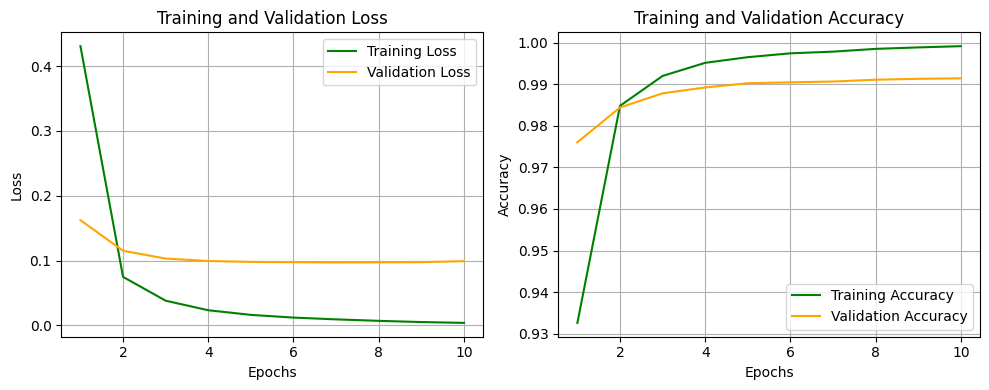

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8567 - loss: 1.0687 - val_accuracy: 0.9738 - val_loss: 0.1751
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9812 - loss: 0.1009 - val_accuracy: 0.9837 - val_loss: 0.1165
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9905 - loss: 0.0446 - val_accuracy: 0.9878 - val_loss: 0.1058
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9945 - loss: 0.0267 - val_accuracy: 0.9892 - val_loss: 0.0998
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9964 - loss: 0.0175 - val_accuracy: 0.9897 - val_loss: 0.0980
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9974 - loss: 0.0128 - val_accuracy: 0.9903 - val_loss: 0.0970
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9980 - loss: 0.0097 - val_accuracy: 0.9907 - val_loss: 0.0964
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9984 - loss: 0.0074 - val_accu

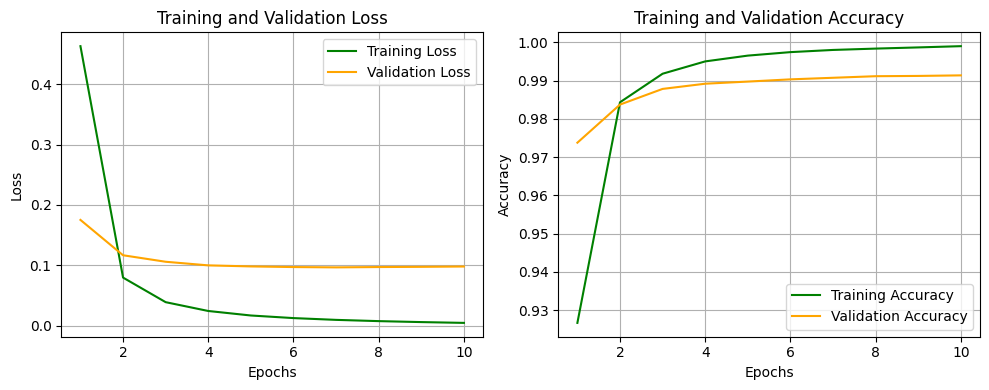

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8483 - loss: 1.1015 - val_accuracy: 0.9675 - val_loss: 0.1881
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9755 - loss: 0.1257 - val_accuracy: 0.9804 - val_loss: 0.1269
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9866 - loss: 0.0619 - val_accuracy: 0.9856 - val_loss: 0.1121
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9922 - loss: 0.0375 - val_accuracy: 0.9878 - val_loss: 0.1046
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9946 - loss: 0.0245 - val_accuracy: 0.9893 - val_loss: 0.1017
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9961 - loss: 0.0177 - val_accuracy: 0.9903 - val_loss: 0.1001
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9972 - loss: 0.0137 - val_accuracy: 0.9909 - val_loss: 0.0998
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9976 - loss: 0.0108 - val_accu

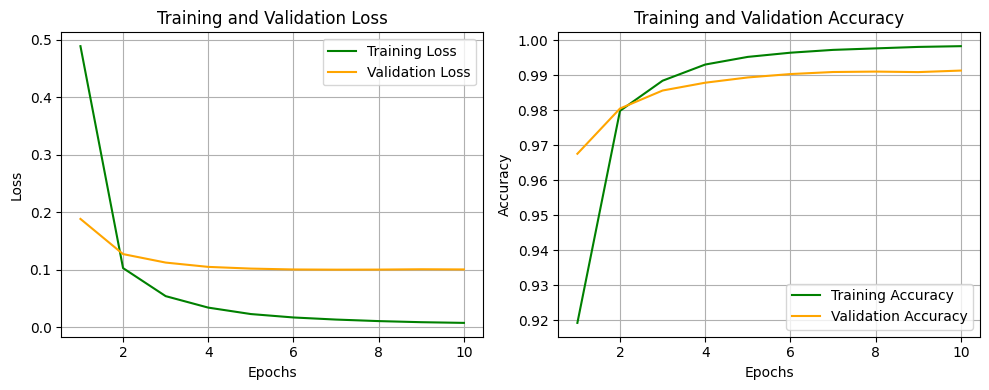

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8349 - loss: 1.1436 - val_accuracy: 0.9685 - val_loss: 0.1923
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9765 - loss: 0.1220 - val_accuracy: 0.9818 - val_loss: 0.1287
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9871 - loss: 0.0605 - val_accuracy: 0.9858 - val_loss: 0.1152
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9915 - loss: 0.0387 - val_accuracy: 0.9878 - val_loss: 0.1071
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9941 - loss: 0.0272 - val_accuracy: 0.9891 - val_loss: 0.1017
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9956 - loss: 0.0194 - val_accuracy: 0.9897 - val_loss: 0.1005
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9967 - loss: 0.0150 - val_accuracy: 0.9903 - val_loss: 0.0994
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9974 - loss: 0.0113 - val_accu

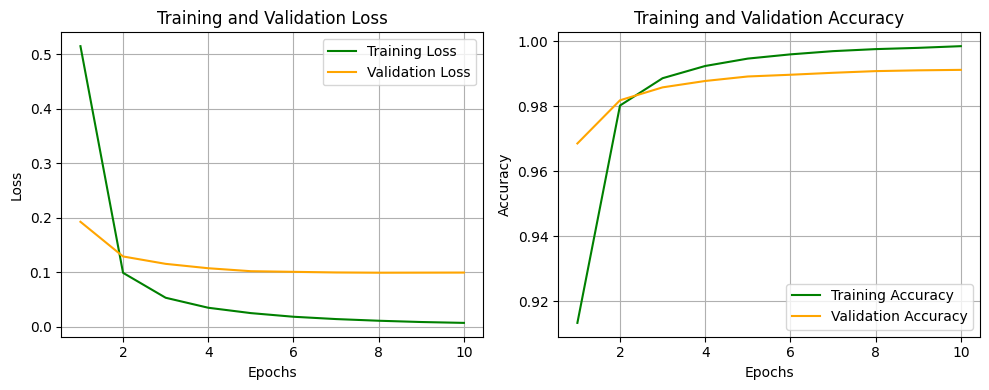

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7852 - loss: 1.2454 - val_accuracy: 0.9502 - val_loss: 0.2520
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9537 - loss: 0.1990 - val_accuracy: 0.9689 - val_loss: 0.1878
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9676 - loss: 0.1335 - val_accuracy: 0.9779 - val_loss: 0.1581
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9755 - loss: 0.0991 - val_accuracy: 0.9804 - val_loss: 0.1439
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9795 - loss: 0.0795 - val_accuracy: 0.9826 - val_loss: 0.1350
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9820 - loss: 0.0668 - val_accuracy: 0.9852 - val_loss: 0.1289
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9842 - loss: 0.0576 - val_accuracy: 0.9865 - val_loss: 0.1243
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9867 - loss: 0.0485 - val_accu

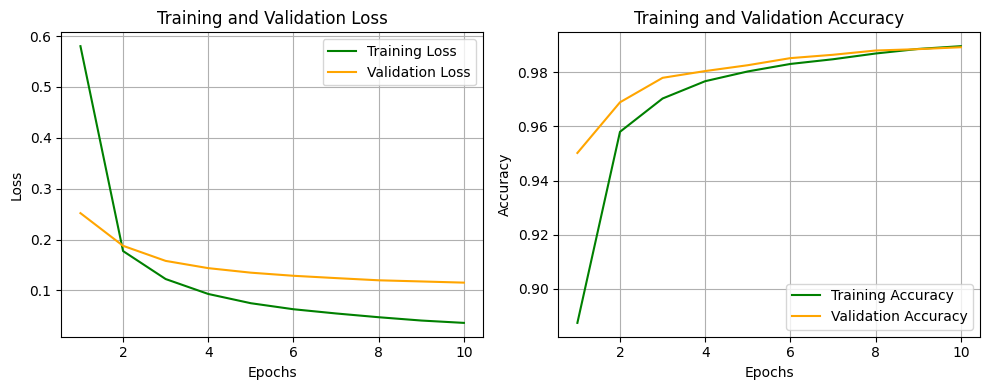

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7870 - loss: 1.2843 - val_accuracy: 0.9499 - val_loss: 0.2517
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9532 - loss: 0.2012 - val_accuracy: 0.9710 - val_loss: 0.1934
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9689 - loss: 0.1354 - val_accuracy: 0.9783 - val_loss: 0.1572
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9768 - loss: 0.0970 - val_accuracy: 0.9811 - val_loss: 0.1417
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9809 - loss: 0.0748 - val_accuracy: 0.9830 - val_loss: 0.1323
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9836 - loss: 0.0620 - val_accuracy: 0.9852 - val_loss: 0.1269
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9864 - loss: 0.0509 - val_accuracy: 0.9868 - val_loss: 0.1218
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9884 - loss: 0.0427 - val_accu

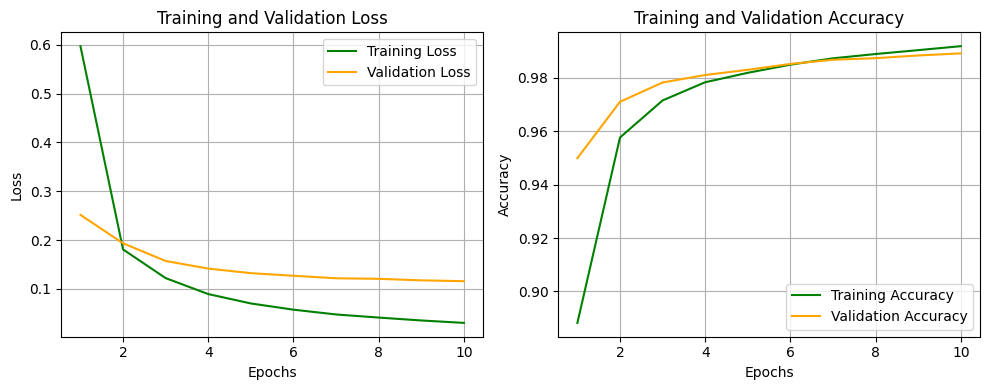

 configuració  val_accuracy  f1_score_val  test_accuracy  f1_score_test
            4      0.991178      0.790498       0.991255       0.721117
            2      0.991372      0.780739       0.990911       0.696119
            1      0.991445      0.777087       0.991010       0.709529
            3      0.991275      0.764143       0.991059       0.704827
            6      0.989167      0.626754       0.989659       0.558485
            5      0.989240      0.587294       0.990101       0.567907


In [ ]:
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

emb = 1000
results = []

for config in range(1,7):
    accuracy_val, accuracy_test, f1_score_val, f1_score_test, history = model(
        train_pad_sequences, val_pad_sequences, test_pad_sequences,
        train_labels_one_hot, val_labels_one_hot, test_labels_one_hot,
        len(unique_words_dict) + 1, emb, max_sequence_length, num_classes, config)
    results.append({
        'configuració': config,
        'val_accuracy': accuracy_val,
        'f1_score_val': f1_score_val,
        'test_accuracy': accuracy_test,
        'f1_score_test': f1_score_test
    })
    plot_curves(history)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

## Model final

Epoch 1/20


C:\Users\marta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.8731 - loss: 1.0239 - val_accuracy: 0.9757 - val_loss: 0.1651
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9828 - loss: 0.0918 - val_accuracy: 0.9843 - val_loss: 0.1148
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9914 - loss: 0.0402 - val_accuracy: 0.9877 - val_loss: 0.1048
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9949 - loss: 0.0237 - val_accuracy: 0.9891 - val_loss: 0.1005
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9966 - loss: 0.0157 - val_accuracy: 0.9899 - val_loss: 0.0986
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9976 - loss: 0.0111 - val_accuracy: 0.9905 - val_loss: 0.0975
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9984 - loss: 0.0080 - val_accuracy: 0.9909 - val_loss: 0.0979
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accurac

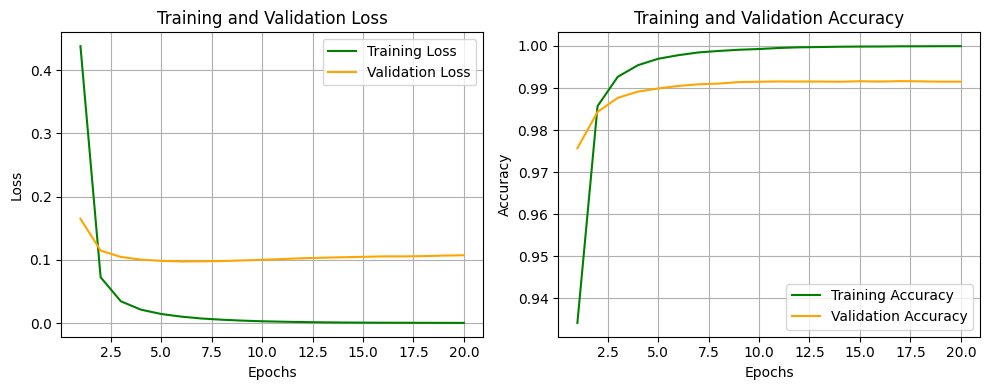

 val_accuracy  f1_score_val  test_accuracy  f1_score_test
     0.991517      0.835674       0.991624       0.763682


In [17]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 1000
vocab_size = len(unique_words_dict) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dense(64, activation='relu'))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

# Compilar el model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenament
batch_size = 32
epochs = 20
history = model.fit(train_pad_sequences, train_labels_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_labels_one_hot))

# Avaluació
loss_val, accuracy_val = model.evaluate(val_pad_sequences, val_labels_one_hot, batch_size=batch_size)
loss_test, accuracy_test = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size)

# F1-SCORE
val_true_labels = np.argmax(val_labels_one_hot, axis=2).flatten()
test_true_labels = np.argmax(test_labels_one_hot, axis=2).flatten()

val_predictions = model.predict(val_pad_sequences, batch_size=batch_size)
test_predictions = model.predict(test_pad_sequences, batch_size=batch_size)

val_predicted_labels = np.argmax(val_predictions, axis=2).flatten()
test_predicted_labels = np.argmax(test_predictions, axis=2).flatten()

f1_score_val = f1_score(val_true_labels, val_predicted_labels, average='macro')
f1_score_test = f1_score(test_true_labels, test_predicted_labels, average='macro')

results = []
results.append({
    'val_accuracy': accuracy_val,
    'f1_score_val': f1_score_val,
    'test_accuracy': accuracy_test,
    'f1_score_test': f1_score_test
})
plot_curves(history)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score_val', ascending=False)
print(results_df.to_string(index=False))

---

<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---